# Combined model of RV and H$\alpha$

## Overall model is quasiperiodic in RV, quasiperiodic in H$\alpha$

<ul>
    <li>Period and decorrelation time are shared between two quasi-periodic kernels; amplitude and roughness can be different.</li>
</ul>

### 1. Get data:

In [21]:
from matplotlib import rcParams
rcParams.update({'font.size': 14, 'font.family': 'serif'})

In [2]:
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
%matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("../data/dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("../data/dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]; allRV = allRV-np.mean(allRV);
allRVerr = allRVerr[sub]
allha = allha[sub]; allha = allha - np.mean(allha);
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

### 2. Plot RV, H$\alpha$, and their periodograms:

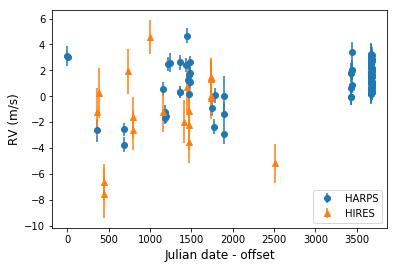

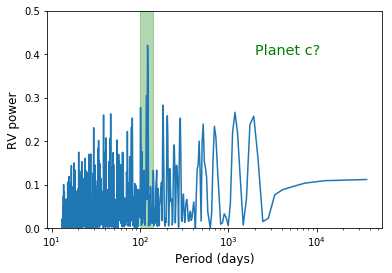

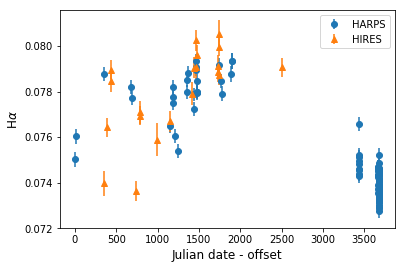

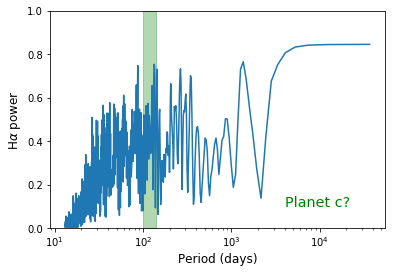

In [3]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

### 3. Set up the Gaussian processes with shared period and decorrelation time; find best-fit parameters:

In [4]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''
# Quasi-periodic kernels
constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_ha = 4.0e-5
gamma_guess_RV = 3. # Amplitudes of periodic part of kernels
gamma_guess_ha = 12.
metric_guess = 50000. # Decorrelation timescale SQUARED (days)
period_guess = 110. # Best-fit period from GP model of RV alone

'''Can experiment with the hyperparameter initial guesses here'''

# Create the kernels
kexp2_RV = constant_guess_RV * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_ha = constant_guess_ha * kernels.ExpSquaredKernel(metric=metric_guess)
kper_RV = kernels.ExpSine2Kernel(gamma=gamma_guess_RV, log_period=np.log(period_guess))
kper_ha = kernels.ExpSine2Kernel(gamma=gamma_guess_ha, log_period=np.log(period_guess))
krot_RV = kexp2_RV * kper_RV
krot_ha = kexp2_ha * kper_ha

# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
'''NOTE: correct way to account for whitenoise is to add uncertainties w/ george's compute() method. Don't use these.'''
#def whitenoise_RV(time):
#    return np.log(allRVerr**2)

#def whitenoise_ha(time):
#    return np.log(allhaerr**2)



# Initialize the Gaussian processes 
gp_RV = GP(krot_RV, fit_kernel=True) #, mean=np.mean(allRV))
gp_ha = GP(krot_ha, fit_kernel=True) #, mean=np.mean(allha))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    period = par_vec[0]
    metric = par_vec[1]
    RV_amp = par_vec[2]
    RV_gamma = par_vec[3]
    ha_amp = par_vec[4]
    ha_gamma = par_vec[5]
    RV_pars = [RV_amp, metric, RV_gamma, period]
    ha_pars = [ha_amp, metric, ha_gamma, period]
    return RV_pars, ha_pars

# Function that takes the two parameter vectors and turns them
# into one master parameter vector; also sanity checks that the
# periods and metrics are the same for the quasiperiodic kernels
def make_par_vec(RVpars, hapars):
    RV_amp = RVpars[0]
    RV_metric = RVpars[1]
    RV_gamma = RVpars[2]
    RV_period = RVpars[3]
    ha_amp = hapars[0]
    ha_metric = hapars[1]
    ha_gamma = hapars[2]
    ha_period = hapars[3]

    assert RV_period == ha_period, "Error: RV and Halpha should have same period"
    assert RV_metric == ha_metric, "Error: RV and Halpha should have same decorrelation timescale"
    master_pars = [RV_period, RV_metric, RV_amp, RV_gamma, \
                   ha_amp, ha_gamma]
    return master_pars

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: period, metric, 
# RV exp2 amplitude, RV gamma, ha exp2 amplitude, ha gamma,
# ha long-term amplitude, ha long-term metric
lower_bounds = [-2., 0., -4., 1.0e-5, -20., 1.0e-5]
upper_bounds = [10., 18., 6., 100., 0., 1000.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)
def nll(gpPars):
    p_RV, p_ha = split_par_vec(gpPars)
    gp_RV.set_parameter_vector(p_RV)
    gp_ha.set_parameter_vector(p_ha)
    ll_RV = gp_RV.log_likelihood(allRV, quiet=True)
    ll_ha = gp_ha.log_likelihood(allha, quiet=True)
    ll = ll_RV + ll_ha
    return -ll if np.isfinite(ll) else 1e25

# You need to compute both GPs before starting the optimization.
gp_RV.compute(alldates,allRVerr)
gp_ha.compute(alldates,allhaerr)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
RV_pars = gp_RV.get_parameter_vector()
ha_pars = gp_ha.get_parameter_vector()
allpars = make_par_vec(RV_pars, ha_pars)
print("Master parameter vector:", allpars)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
results = minimize(nll, allpars, method="TNC", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood, BIC, and results
results_RV, results_ha = split_par_vec(results.x)
final_loglike = -nll(results.x)
npts = len(alldates)
npars = len(allpars)
bic = np.log(npts) * npars - 2.*final_loglike
print("Final ln-likelihood:", final_loglike)
print(results)
gp_RV.set_parameter_vector(results_RV)
gp_ha.set_parameter_vector(results_ha)
print('\n',gp_RV.get_parameter_dict())
print('\n',gp_ha.get_parameter_dict())
print("\nBayesian information criterion: %4.2f" % bic)

Master parameter vector: [4.700480365792417, 10.819778284410283, 2.0794415416798357, 3.0, -10.126631103850338, 12.0]
Initial ln-likelihood: 414.9407777991046
Final ln-likelihood: 436.414475495784
     fun: -436.414475495784
     jac: array([-0.77839104, -1.24766757, -0.64383698, -0.33080596, -0.30729552,
       -0.0163709 ])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 826
     nit: 122
  status: 1
 success: True
       x: array([  4.82704395,  12.83375153,   1.92309368,  12.16402916,
       -12.22338446,  69.23443921])

 OrderedDict([('kernel:k1:k1:log_constant', 1.9230936753260917), ('kernel:k1:k2:metric:log_M_0_0', 12.833751529043054), ('kernel:k2:gamma', 12.164029158756918), ('kernel:k2:log_period', 4.827043950224677)])

 OrderedDict([('kernel:k1:k1:log_constant', -12.223384461501759), ('kernel:k1:k2:metric:log_M_0_0', 12.833751529043054), ('kernel:k2:gamma', 69.2344392114361), ('kernel:k2:log_period', 4.827043950224677)])

Bayesian information criterion: -844.52


#### Human-readable parameters:

In [5]:
print("Period:", np.exp(results.x[0]), ' days \n')
print("Metric:", np.exp(results.x[1]), ' days squared')
print("Decorrelation timescale (sqrt of metric):", np.sqrt(np.exp(results.x[1])), ' days \n')
print("Constant RV kernel multiplier:", np.exp(results.x[2]))
print("Sqrt of constant RV kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[2])), '\n')
print("Gamma (multiplier of sin2) for RV:", results.x[3])
print("Roughness parameter omega for RV:", np.sqrt(0.5/results.x[3]), '\n')
print("Constant Halpha quasiperiodic kernel multiplier:", np.exp(results.x[4]))
print("Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[4])), '\n')
print("Gamma (multiplier of sin2) for Halpha:", results.x[5])
print("Roughness parameter omega for Halpha:", np.sqrt(0.5/results.x[5]), '\n')


Period: 124.84137734510878  days 

Metric: 374651.4960743234  days squared
Decorrelation timescale (sqrt of metric): 612.0878172895809  days 

Constant RV kernel multiplier: 6.84209297500069
Sqrt of constant RV kernel multiplier (physically meaningful): 2.6157394700162113 

Gamma (multiplier of sin2) for RV: 12.164029158756918
Roughness parameter omega for RV: 0.20274319019455195 

Constant Halpha quasiperiodic kernel multiplier: 4.914185862609235e-06
Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): 0.0022167963060708206 

Gamma (multiplier of sin2) for Halpha: 69.2344392114361
Roughness parameter omega for Halpha: 0.08498140612221489 



RV_pars = [RV_amp, metric, RV_gamma, period]

In [6]:
import pandas as pd

pd.DataFrame({'Parameter in GP':['log_period', 'log(decor time^2)', 'RV log_amp', 'RV Gamma', None,\
                                 r'H$\alpha$ log_amp', r'H$\alpha$ Gamma', None],
              'Value in GP': [results_RV[3], results_RV[1], results_RV[0], results_RV[2], None,results_ha[0], results_ha[2], None],
              'Parameter': ['Period (day)', 'Decorrelation Timescale (day)', 'RV Amplitude', \
                            'RV Gamma', r'RV Roughness parameter $\omega$', \
                            r'H$\alpha$ Amplitude', r'H$\alpha$ Gamma', r'H$\alpha$ Roughness parameter $\omega$'], 
              'Value': [np.exp(results_RV[3]), np.sqrt(np.exp(results_RV[1])), \
                        np.exp(results_RV[0]), results_RV[2], np.sqrt(0.5/results_RV[2]), \
                        np.exp(results_ha[0]), results_ha[2],np.sqrt(0.5/results_ha[2])]
             })

,Parameter in GP,Value in GP,Parameter,Value
0,log_period,4.827044,Period (day),124.841377
1,log(decor time^2),12.833752,Decorrelation Timescale (day),612.087817
2,RV log_amp,1.923094,RV Amplitude,6.842093
3,RV Gamma,12.164029,RV Gamma,12.164029
4,None,NaN,RV Roughness parameter $\omega$,0.202743
5,H$\alpha$ log_amp,-12.223384,H$\alpha$ Amplitude,0.000005
6,H$\alpha$ Gamma,69.234439,H$\alpha$ Gamma,69.234439
7,None,NaN,H$\alpha$ Roughness parameter $\omega$,0.084981


$$
k_{i, j}=A \exp \left[-\frac{\left(t_{i}-t_{j}\right)^{2}}{\lambda^{2}}-\frac{1}{2 \omega^{2}} \sin ^{2}\left(\frac{\pi\left(t_{i}-t_{j}\right)}{P}\right)\right]+\sigma_{i}^{2} \delta_{i j}
$$

### 4. Use <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a> to sample the Gaussian processes:
<ol>
<li>Visualize radial velocity and H$\alpha$ curves that are consistent with our rotation model, and</li>
<li>Find the uncertainties on our model parameters.</li>
</ol>

In [7]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian processes again
gp_RV.compute(alldates,allRVerr)
gp_ha.compute(alldates,allhaerr)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 50, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels
p0[:,4] = pstart[4] + 1.0e-8 * np.random.randn(nwalkers)
#period:
#p0[:,0] = pstart[0] + 2.0 * np.random.randn(nwalkers)
print("Running burn-in")
nburn = 500
p0, _, _ = sampler.run_mcmc(p0, nburn, progress=True)

print("Running production chain")
nproduce = 8000
sampler.run_mcmc(p0, nproduce, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

  0%|          | 0/500 [00:00<?, ?it/s]

Computed the Gaussian processes
Running burn-in


  0%|          | 0/8000 [00:00<?, ?it/s]

Running production chain


100%|██████████| 8000/8000 [11:52<00:00, 11.23it/s]

Mean acceptance fraction: 0.448


### 5. Examine RV and H$\alpha$ time series predicted by the Gaussian processes:

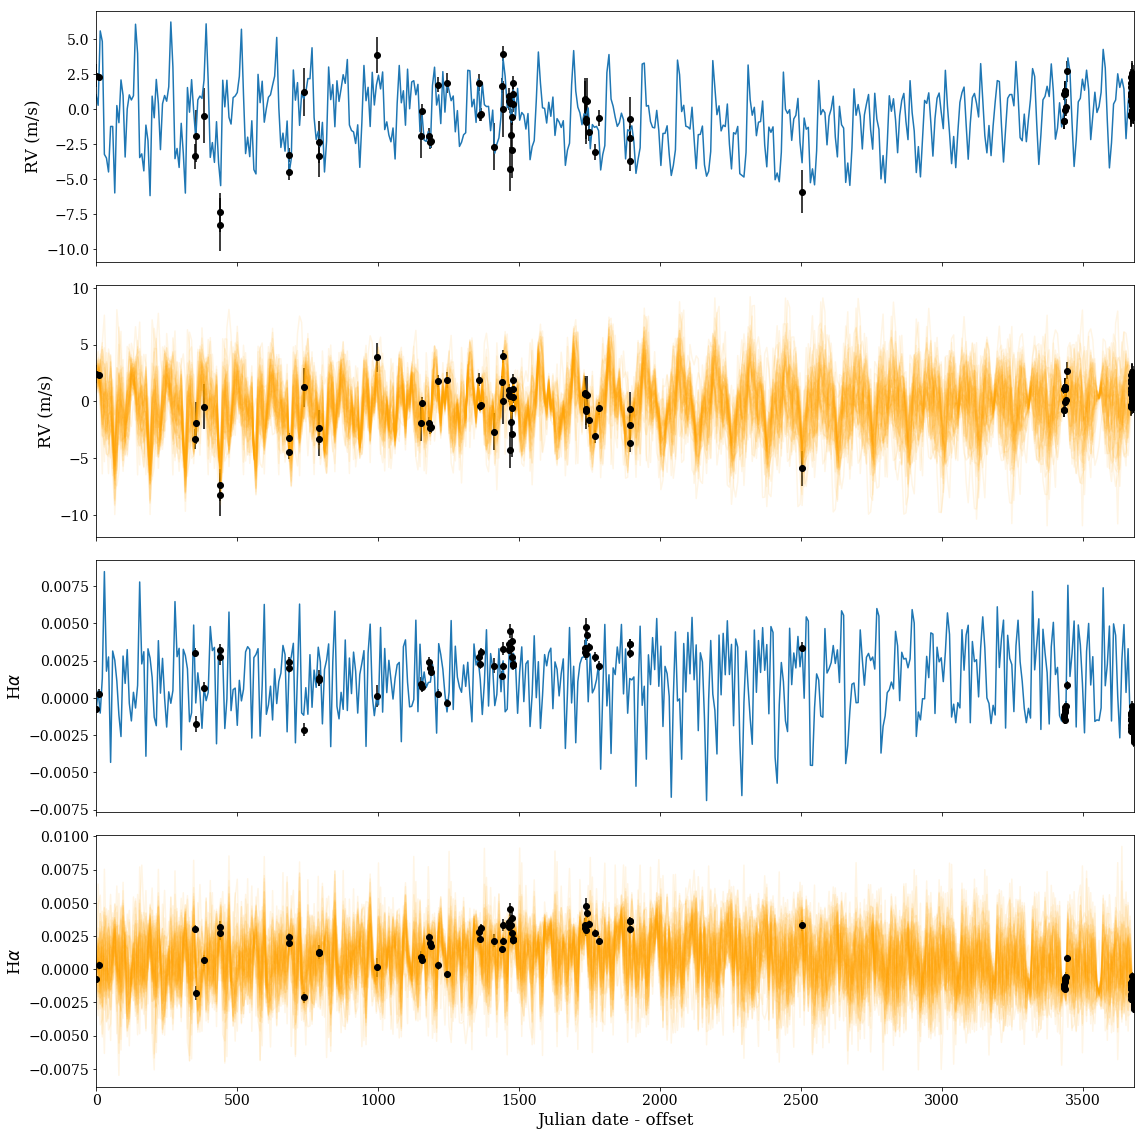

In [31]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

# Plot 50 possible RV curves drawn from the flat chain, along with the data
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, sharex=True, figsize=(16,16))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)

#Plot the real data
for ax in [ax1, ax2]:
    ax.errorbar(alldates, allRV, yerr=allRVerr, c='k',fmt='o')
for ax in [ax3, ax4]:
    ax.errorbar(alldates, allha, yerr=allhaerr, c='k',fmt='o')

for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    spars_RV, spars_ha = split_par_vec(samples[n])
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    gp_RV.recompute()
    gp_ha.recompute()
    # Plot a single sample.
    ax2.plot(tt, gp_RV.sample_conditional(allRV, tt), "orange", alpha=0.1)
    ax4.plot(tt, gp_ha.sample_conditional(allha, tt),  "orange",alpha=0.1)

#Plot one sample
n = np.random.randint(0, samples.shape[0])
spars_RV, spars_ha = split_par_vec(samples[n])
gp_RV.set_parameter_vector(spars_RV)
gp_ha.set_parameter_vector(spars_ha)
gp_RV.recompute()
gp_ha.recompute()
# Plot a single sample.
ax1.plot(tt, gp_RV.sample_conditional(allRV, tt),  alpha=1)
ax3.plot(tt, gp_ha.sample_conditional(allha, tt),  alpha=1)


#ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
#ax2.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax4.set_xlim(alldates[0], alldates[-1])
ax4.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("RV (m/s)", fontsize='large')
ax2.set_ylabel("RV (m/s)", fontsize='large')
ax3.set_ylabel(r"H$\alpha$", fontsize='large')
ax4.set_ylabel(r"H$\alpha$", fontsize='large')

fig.tight_layout()

Recomputed before `gp.sample_conditional()`
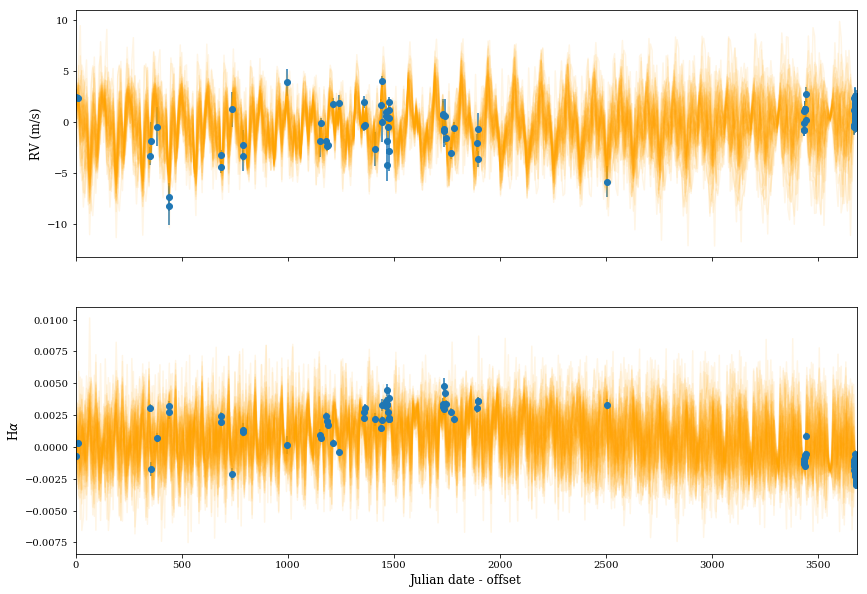

Strongest period signal in RV residuals: 88.72423662482032
False Alarm Prob.: 0.28400000000000003


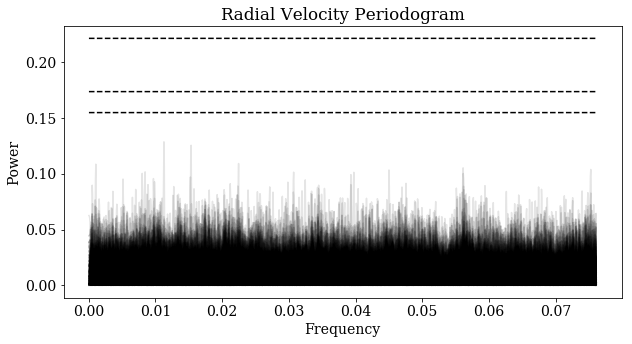

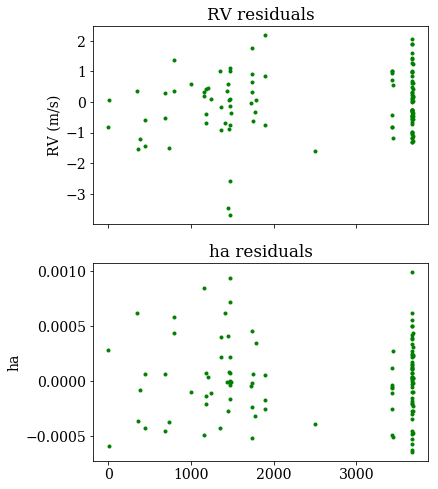

In [40]:
size = 300
burnin =nburn
thin=6
RV_pds = np.zeros(size)
RV_pwr = np.zeros(size)
RV_fa = np.zeros(size)
ha_pds = np.zeros(size)
ha_pwr = np.zeros(size)
ha_fa = np.zeros(size)
fig, (ax1) = plt.subplots(1, sharex=False, figsize=(10,5))
samples = sampler.get_chain(discard=burnin, flat=True, thin =thin)
for r in range(size):
    spars_RV, spars_ha = split_par_vec(samples[r])
    gp_RV.set_parameter_vector(spars_RV)
    
    #get residuals
    resid = allRV - gp_RV.sample_conditional(allRV,alldates)
    
    #periodogram
    ls = LombScargle(alldates, resid, allRVerr)
    xi, pspec = ls.autopower()
    sub = np.argmax(pspec)
    RV_pds[r] = 1.0/xi[sub]
    RV_pwr[r] = pspec[sub]
    
    
    gp_ha.set_parameter_vector(spars_ha)
    #repeat for ha
    resida = allha - gp_ha.sample_conditional(allha,alldates)
    
    #plot 
    ax1.plot(xi, pspec, 'k-', alpha=0.1)   
    
    
fig, (ax3, ax4) = plt.subplots(2, sharex=True, figsize=(6,8))
ax3.plot(alldates, resid,'g.')
ax3.set_title('RV residuals')
ax3.set_ylabel("RV (m/s)")
ax4.plot(alldates, resida,'g.')
ax4.set_title('ha residuals')
ax4.set_ylabel("ha")


probabilities = [0.05, 0.01, 0.1]
levels = ls.false_alarm_level(probabilities, method='bootstrap')
level1 = np.zeros(len(xi))
level2 = np.zeros(len(xi))
level3 = np.zeros(len(xi))
for i in range(len(level1)):
    level1[i] = levels[0]
    level2[i] = levels[1]
    level3[i] = levels[2]
ax1.plot(xi,level1,'k--')
ax1.plot(xi,level2,'k--')
ax1.plot(xi,level3,'k--')


    

ax1.set_xlabel("Frequency")
ax1.set_title("Radial Velocity Periodogram")
ax1.set_ylabel("Power")


idx1 = np.argmax(RV_pwr)
print('Strongest period signal in RV residuals:',RV_pds[idx1])
print('False Alarm Prob.:', ls.false_alarm_probability(RV_pwr[idx1],method = 'bootstrap'))


### 6. Examine posteriors and covariances:

In [29]:
rcParams.update({'font.size': 14, 'font.family': 'serif'})

In [13]:
import corner
parnames = ["ln(Period)", "ln(decorr time$^2$)", "ln(RV Quasi-per amp)", \
            "RV Gamma", "ln(Ha Quasi-per amp)", "Ha Gamma"]
cfig = corner.corner(samples, labels=parnames)

Bin containing most probable period: 12.6 -- 375.5 days
Bin containing most probable decorrelation time: 671.9 -- 746.4 days
Bin containing 2nd most probable decorrelation time: 597.4 -- 671.9 days

Period: 16, 50, 84 percentiles = 124.53 124.75 244.15 days
Decorrelation time: 16, 50, 84 percentiles = 437.46 661.79 833.41 days

Period = 124.75 +119.40 -0.22 days
Decorrelation time = 661.79 +171.62 -224.33 days


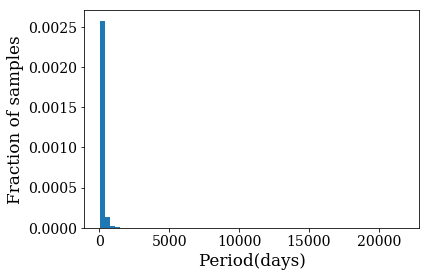

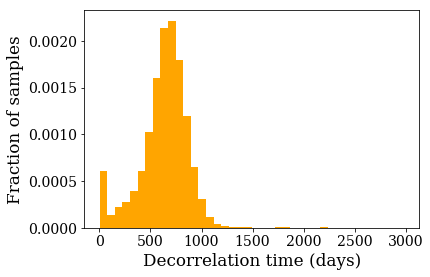

In [264]:
# Plots
plt.figure()
periods = np.exp(samples[:,0])
dctimes = np.exp(0.5*samples[:,1])
n_per, bins_per, _ = plt.hist(periods, 60, density=True)
plt.xlabel("Period(days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')
#plt.xlim([0,1000])
plt.figure()
n_dc, bins_dc, _ = plt.hist(dctimes, 40, density=True, facecolor='orange')
plt.xlabel("Decorrelation time (days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')

# Numbers
per_bestbin = np.argmax(n_per)
dc_bestbin = np.argmax(n_dc)
dc_sort = np.argsort(n_dc)
print("Bin containing most probable period: %4.1f -- %4.1f days" \
      % (bins_per[per_bestbin], bins_per[per_bestbin+1]))
print("Bin containing most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_bestbin], bins_dc[dc_bestbin+1]))
print("Bin containing 2nd most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_sort[-2]], bins_dc[dc_sort[-2]+1]))
pctiles = [16, 50, 84]
pervals = np.percentile(periods, pctiles)
dcvals = np.percentile(dctimes, pctiles)
print("\nPeriod: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (pervals[0], pervals[1], pervals[2]), "days")
print("Decorrelation time: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (dcvals[0], dcvals[1], dcvals[2]), "days")

# Amusing myself with python's crazy way of interpreting lists and tuples
# Now I have a fun formatting example for future reference! (adapted from
# emcee tutorial)
po, dco = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
              zip(*np.percentile(np.column_stack((periods, dctimes)), \
              pctiles, axis=0)))
print("\nPeriod = %4.2f +%4.2f -%4.2f" % po, "days")
print("Decorrelation time = %4.2f +%4.2f -%4.2f" % dco, "days")

Text(0.5, 0, 'Step number')

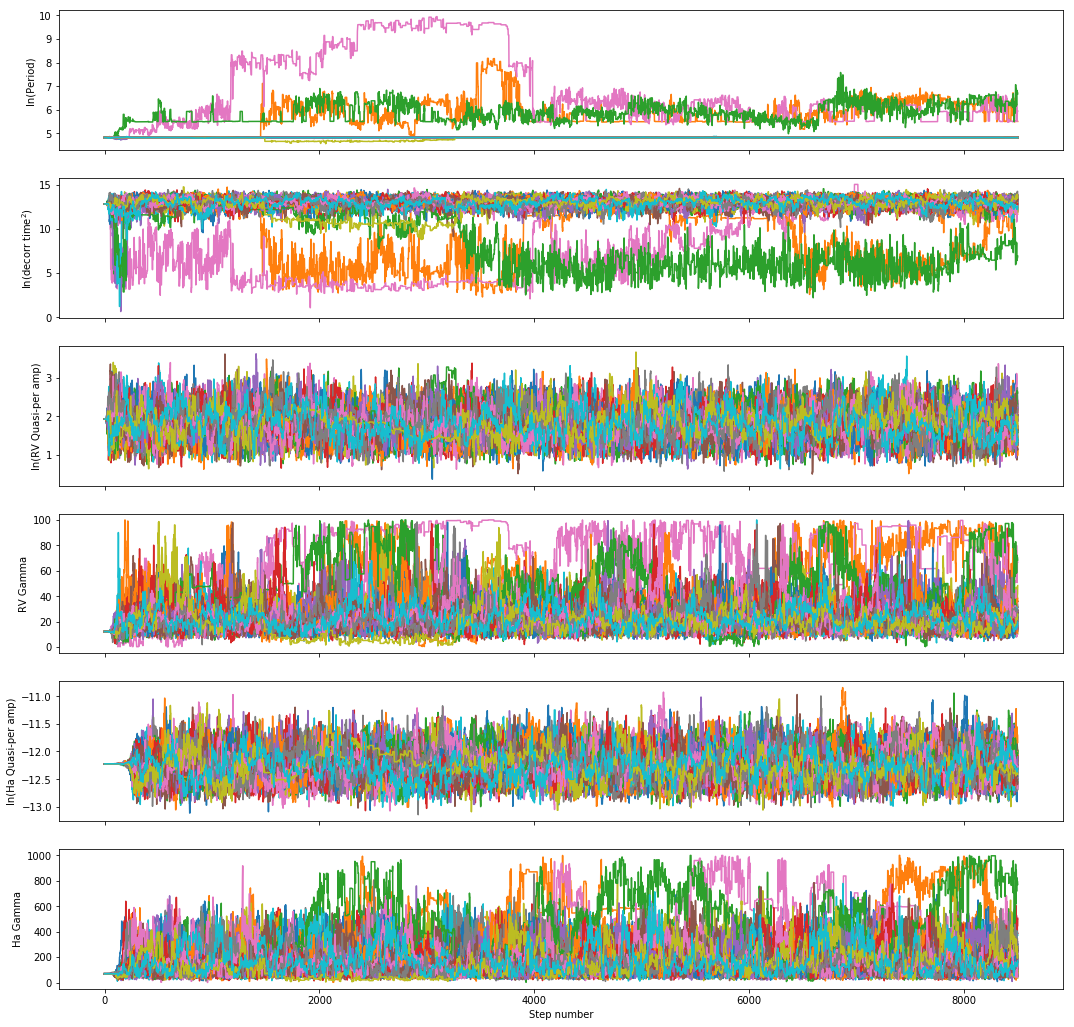

In [14]:
fig, axarr = plt.subplots(6, sharex=True, figsize=(18,18))
nsteps = nburn + nproduce
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[5].set_xlabel('Step number')

### $\chi^2$

In [131]:
np.square(allRVerr)

array([0.64  , 0.0729, 0.7921, 3.4225, 3.8416, 1.9044, 3.5344, 0.2704,
       0.3481, 3.0276, 2.3104, 2.25  , 1.69  , 2.4649, 0.2809, 0.3136,
       0.2304, 0.2304, 0.2916, 0.5329, 0.3481, 0.2025, 0.2025, 2.7556,
       0.2916, 0.3136, 3.9601, 0.3721, 0.3249, 0.5476, 2.4336, 1.7161,
       0.3136, 3.8809, 0.3025, 0.2401, 0.2809, 2.3104, 1.6384, 2.1025,
       2.4649, 2.8224, 0.36  , 0.3249, 0.3364, 0.7225, 2.4336, 0.5776,
       2.3409, 0.36  , 0.36  , 0.1849, 0.1521, 0.5776, 0.5184, 0.5329,
       0.3481, 0.5625, 0.5625, 0.36  , 0.6889, 0.3025, 0.3364, 0.5625,
       0.2809, 0.4096, 0.3249, 0.3844, 0.3364, 0.2601, 0.4225, 0.4225,
       0.1849, 0.3025, 0.2809, 0.3249, 0.2025, 0.4356, 0.5476, 0.3721,
       0.2704, 0.3721, 0.3969, 0.5776, 0.9604, 0.2601, 0.3025, 0.4489,
       0.2704, 0.2304, 0.6561, 0.3844, 0.1681, 0.7396, 0.3481, 0.4761,
       0.4225, 0.3481, 0.5041, 0.6724, 0.6889, 0.2809, 0.3481, 0.4096,
       0.3844, 0.4356, 0.5329, 0.3721, 0.3136, 0.6241, 0.3249, 0.5184])

In [41]:
#calculate reduced chi^2 value of model (average from a number of samples)
N = len(alldates)
n = 100
chi = np.zeros(n)
for i in range(n):
    resid = allRV - gp_RV.sample_conditional(allRV,alldates)
    s = np.square(resid)/(np.square(allRVerr))
    s = np.sum(s)
    chi[i] = s/(N-npars-1)
print(np.mean(chi))

1.8426024586850525


Text(0.5,1,'BIC Distribution')

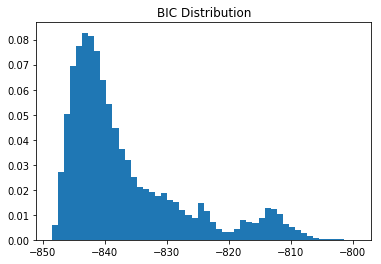

In [21]:
nsamples = nwalkers * nproduce
bics = np.zeros(nsamples)
for i in range(nsamples):
    bics[i] = np.log(npts) * npars + 2.*nll(samples[i,:])
n_bics, bins_bics, _ = plt.hist(bics, 50, density=True)
plt.title("BIC Distribution")

## Test

In [43]:
def gelman_rubin(chain):
    
    def rscore(x, num_samples):
        # Calculate between-chain variance
        B = num_samples * np.var(np.mean(x, axis=1), axis=0, ddof=1)

        # Calculate within-chain variance
        W = np.mean(np.var(x, axis=1, ddof=1), axis=0)

        # Estimate of marginal posterior variance
        Vhat = W * (num_samples - 1) / num_samples + B / num_samples

        return np.sqrt(Vhat / W)
    
    Rhat = {}
    varnumber = chain.shape[2]
    
    for var in range(varnumber):
        x = chain[:,:,var]
        numsaples = x.shape[1]
        Rhat[str(var)] = rscore(x,numsaples)
    
    return Rhat



In [44]:
print("Gelmen-Rubin Diagnostic:")
gelman_rubin(sampler.chain[:,2000:,:])

Gelmen-Rubin Diagnostic:


{'0': 1.832383659867042,
 '1': 1.6840661246843873,
 '2': 1.0084701870291741,
 '3': 1.3331624514021583,
 '4': 1.010900879618127,
 '5': 1.2027996125768838}

In [39]:
max_n = 30000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
for sample in sampler.sample(p0, iterations=max_n, progress=True):  # sampler.sample is the same with sampler.run_mcmc
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 200 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 90%|█████████ | 27000/30000 [41:23<04:37, 10.83it/s] 


In [40]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.483


In [41]:
tau

array([134.33754081, 105.3788699 ,  78.59708322, 101.3267688 ,
        82.31281205, 110.70850512])

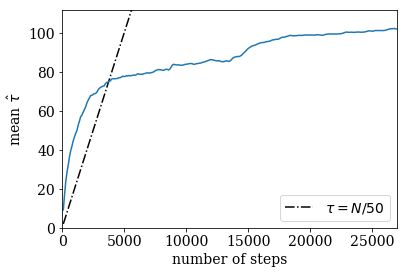

In [42]:
n = 100*np.arange(1, index+1)
y = autocorr[:index]
#plt.plot(n, n / 100.0, "--k", label=r'$\tau = N/100$')
plt.plot(n, n / 50.0, "-.k", label=r'$\tau = N/50$')
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");
#plt.xscale('log')
plt.legend()

In [ ]:
rcParams.update({'font.size': 14, 'font.family': 'serif'})

burn-in: 268
thin: 39
flat chain shape: (34250, 6)


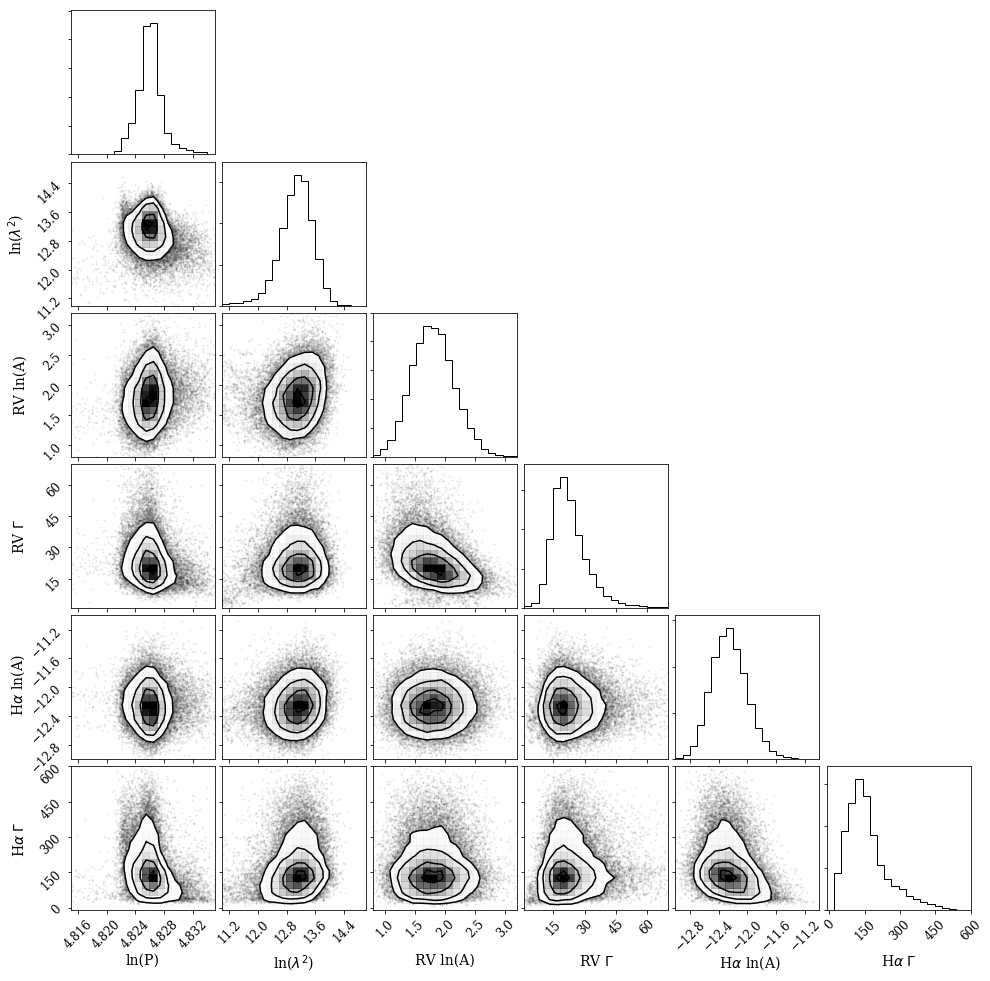

In [90]:
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin =thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
#print("flat log prob shape: {0}".format(log_prob_samples.shape))

#all_samples = np.concatenate((samples, log_prob_samples[:, None]), axis=1)

parnames = ["ln(P)", "ln($\lambda^2$)", "RV ln(A)", \
            "RV $\Gamma$", r' H$\alpha$ ln(A)', r'H$\alpha \ \Gamma$']
#parnames += ["log prob"]
cfig = corner.corner(samples, labels=parnames,range=[(4.815,4.835),(11,15),(0.8,3.2),(1,70),(-13,-11), (-11,600)])

for ax in cfig.get_axes():
    ax.tick_params(which='major',labelsize=12)

In [70]:
cfig.get_axes()[0].tick_params(axis='both', labelsize=4)

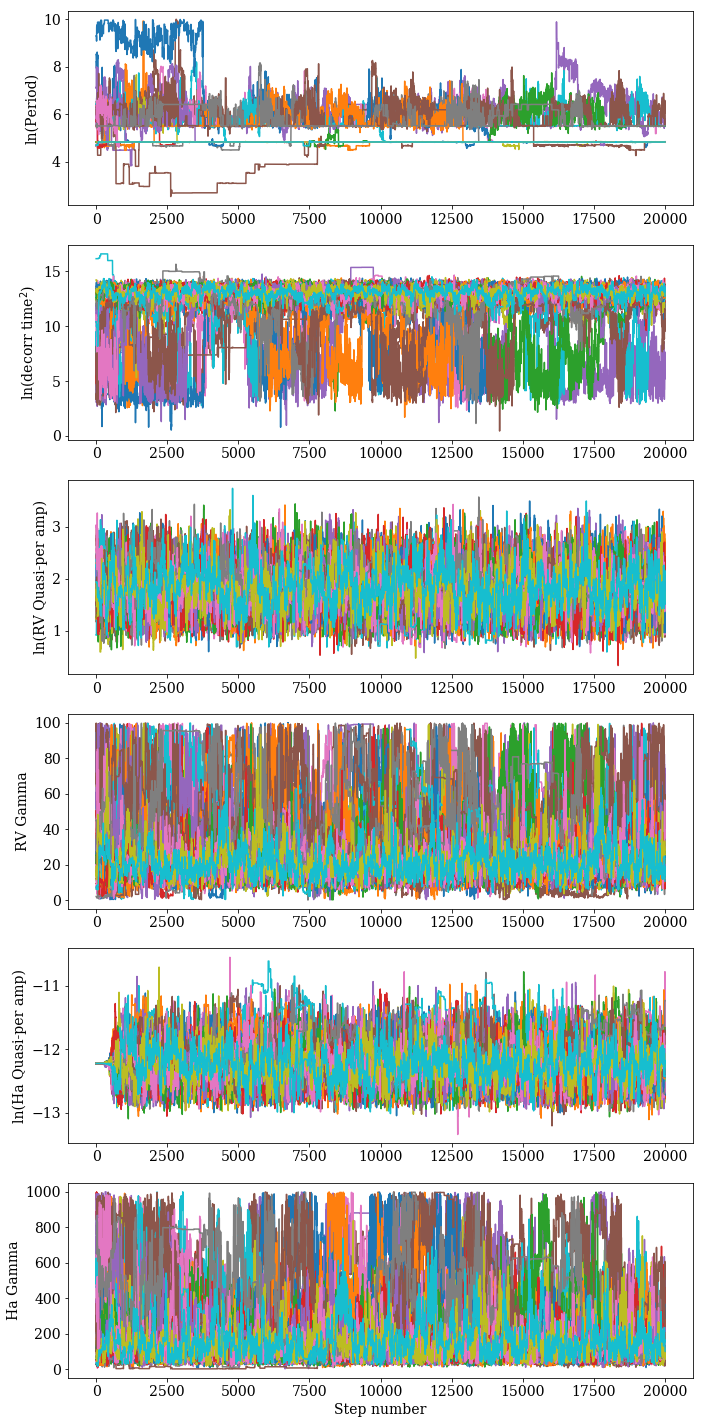

In [232]:
fig, axarr = plt.subplots(6, figsize=(10,20))
nsteps = sampler.chain.shape[1]
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[5].set_xlabel('Step number')
plt.tight_layout()

### ln(Period):

Text(0.5, 0, 'Step number')

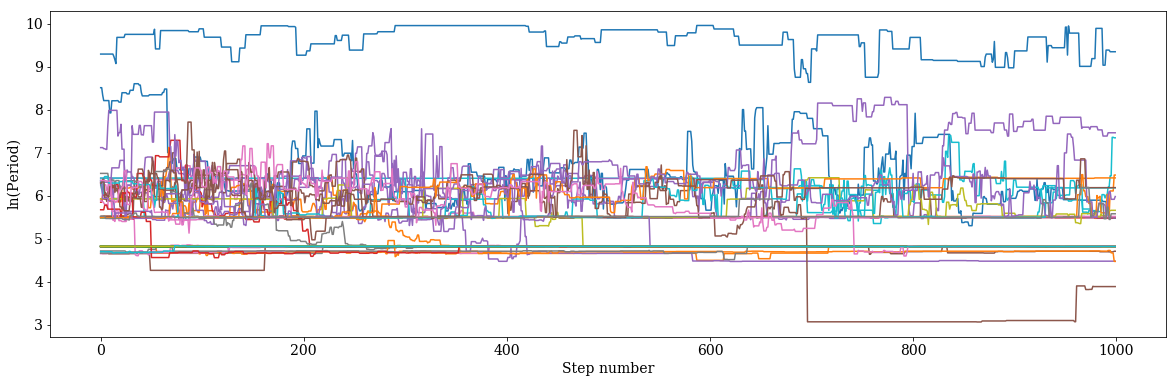

In [258]:
plt.figure(figsize=(20,6))
for w in range(nwalkers):
    plt.plot(sampler.chain[w,:1000,0])
    
plt.ylabel('ln(Period)')
plt.xlabel('Step number')

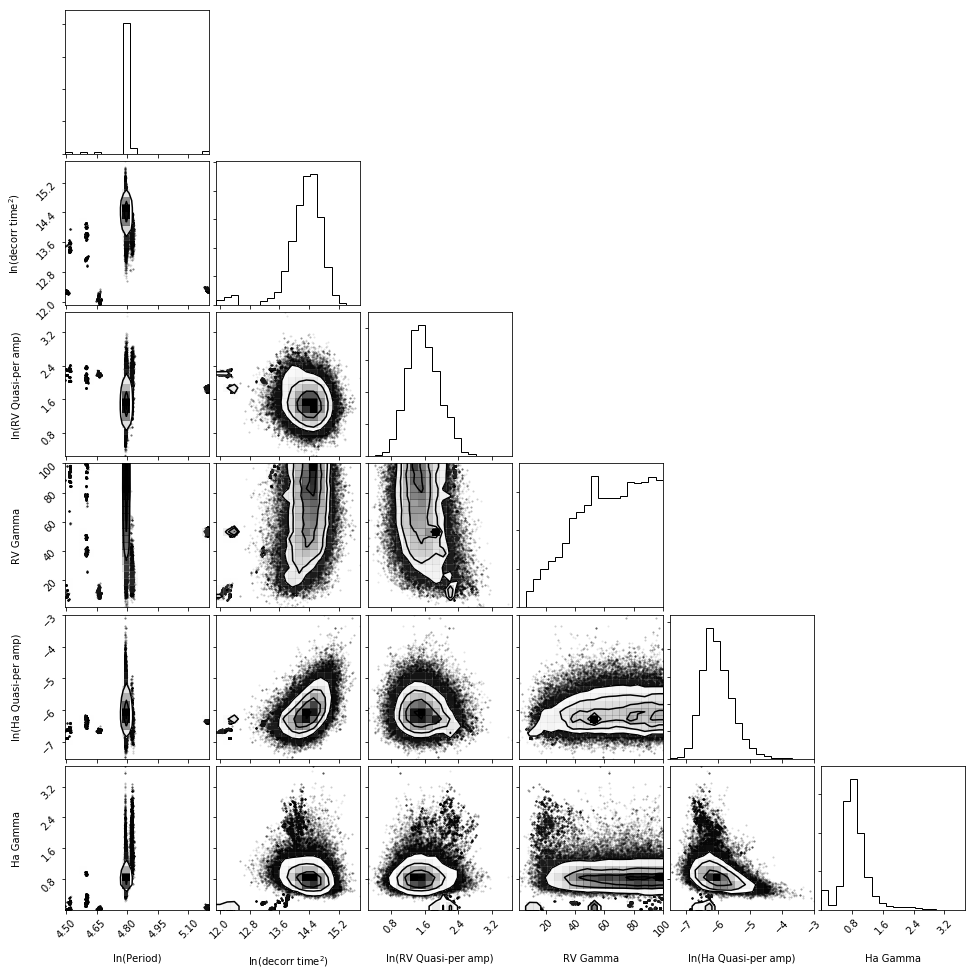

Period: 125.51446973147713 days


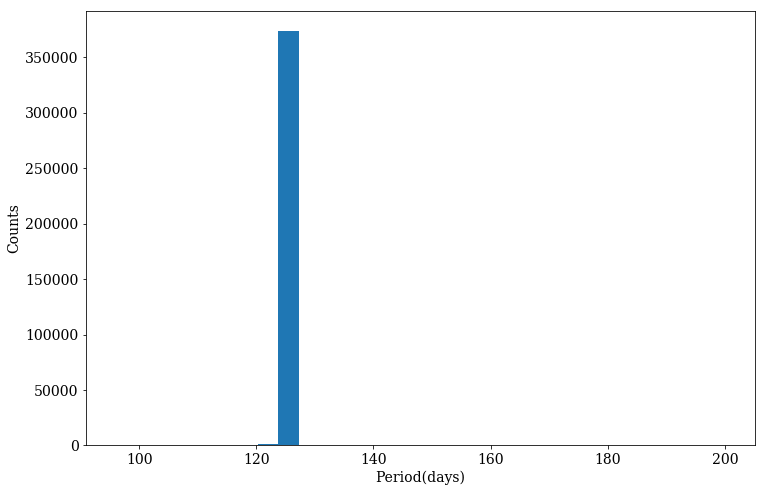

In [37]:
plt.figure(figsize=(12,8))
Period1 = np.exp(samples[:,0])
n, bins, _ =plt.hist(Period1[np.where(Period1<200)], 30)
#plt.xscale('log')
#plt.xlim(100, 150)
plt.xlabel('Period(days)')
sub_n = np.argmax(n)
print('Period: {} days'.format(0.5*(bins[sub_n]+bins[sub_n+1])))
plt.ylabel('Counts')
#plt.xticks(np.arange(50,200,10));
plt.show()

Decorr time: 647.4083463264691 days


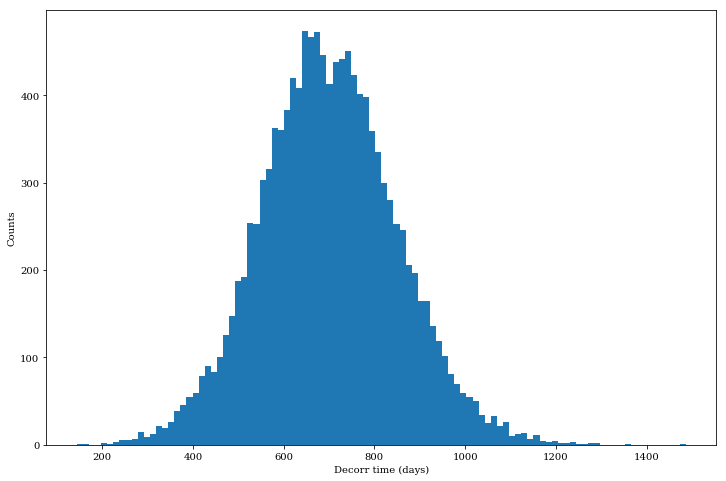

In [146]:
plt.figure(figsize=(12,8))
n, bins, _ =plt.hist(np.sqrt(np.exp(samples[:,1])), 100)
#plt.xscale('log')
#plt.xlim(-1, 100)
plt.xlabel('Decorr time (days)')
sub_n = np.argmax(n)
print('Decorr time: {} days'.format(0.5*(bins[sub_n]+bins[sub_n+1])))
plt.ylabel('Counts')
plt.show()

## Residues:

In [38]:
from scipy.signal import find_peaks
from astropy.stats import LombScargle

# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#plt.figure(figsize=(15,6))
# Plot 50 possible RV curves drawn from the flat chain, along with the data
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
pds = np.zeros(500)
pspecs = np.zeros(500)
specs =np.array([])
periods = np.array([])

pdsha = np.zeros(500)
pspecsha = np.zeros(500)
specsha =np.array([])
periodsha = np.array([])
fig, (ax1,ax2) = plt.subplots(2, figsize=(8,10))

for r in range(500):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    spars_RV, spars_ha = split_par_vec(samples[n])
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    
    #get residuals
    resid = allRV - gp_RV.sample_conditional(allRV,alldates) 
    residha = allha - gp_ha.sample_conditional(allha, alldates)
    
    #periodogram
    xi, pspec = LombScargle(alldates, resid, allRVerr).autopower()
    sub = np.argmax(pspec)
    pds[r] = 1.0/xi[sub]
    pspecs[r] = pspec[sub]
    ax1.plot(xi, pspec, 'b-', alpha=0.01)
    
    #ha periodogram
    xiha, pspecha = LombScargle(alldates, residha, allhaerr).autopower()
    subha = np.argmax(pspecha)
    pdsha[r] = 1.0/xiha[subha]
    pspecsha[r] = pspecha[subha]
    ax2.plot(xiha, pspecha, 'b-', alpha=0.01)
    
    #find the first 10 highest peaks.
    peaks, _ = find_peaks(pspec, height=0.06)
    ind = np.argsort(pspec[peaks])
    ind = peaks[ind[-10:]]
    
    #ha
    peaksha, _ = find_peaks(pspecha, height=0.06)
    indha = np.argsort(pspecha[peaksha])
    indha = peaksha[indha[-10:]]
    
    #rv
    periods = np.append(periods,1.0/xi[ind])
    specs = np.append(specs, pspec[ind])
    
    #ha
    periodsha = np.append(periodsha,1.0/xiha[indha])
    specsha = np.append(specsha, pspecha[indha])
    
ax1.set_title('Periodogram of residues - RV')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
#plt.xscale('log')
ax1.plot(1.0/pds[np.argmax(pspecs)], np.max(pspecs),'r.')
print('The maximum power is {:.4f} days'.format(pds[np.argmax(pspecs)]))
#ha
ax2.set_title('Periodogram of residues - Halpha')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')
#plt.xscale('log')
ax2.plot(1.0/pdsha[np.argmax(pspecsha)], np.max(pspecsha),'r.')
print('The maximum power is {:.4f} days'.format(pdsha[np.argmax(pspecsha)]))

plt.tight_layout()

NameError: name 'burnin' is not defined

#### The distribution of periods in residues:

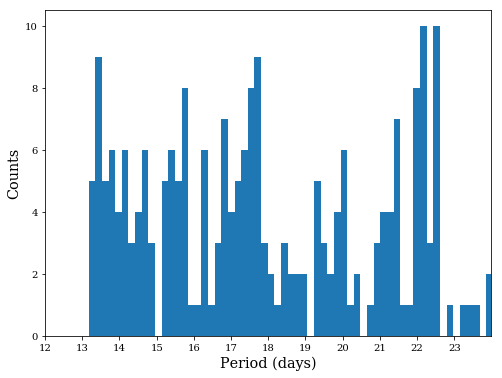

In [151]:
plt.figure(figsize=(8,6))
N, bins, _=plt.hist(periods[np.where(periods<40)],bins=150)
plt.xlim(12,24)
plt.xlabel('Period (days)',fontsize='x-large')
plt.ylabel('Counts',fontsize='x-large');
#plt.title('Distribution of the first 5 dominant periods of each residue',fontsize='x-large')
plt.xticks(np.arange(12,24));

In [152]:
#calculate reduced chi^2 value of model (average from a number of samples)
N = len(alldates)
n = 100
chi = np.zeros(n)
samples = sampler.get_chain(discard=burnin, flat=True, thin =thin)
    
for i in range(n):
    spars_RV, spars_ha = split_par_vec(samples[i])
    gp_RV.set_parameter_vector(spars_RV)
    
    resid = allRV - gp_RV.sample_conditional(allRV,alldates)
    s = np.square(resid)/(np.square(allRVerr))
    s = np.sum(s)
    chi[i] = s/(N-npars-1)
print(np.mean(chi))

1.846690034462481


In [120]:
N-npars-1

105